# Turning Neuromorphic Dynex Chips into Torch Layers

In [1]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch.optim import Adam

## Import dnx layer classes

In [2]:
from HybridQRBM.pytorchdnx import dnx
from HybridQRBM.optimizers import RBMOptimizer
from HybridQRBM.samplers import DynexSampler

## Parameters

In [6]:
# define training hyperparameters
INIT_LR    = 1e-3
BATCH_SIZE = 12000 #64
EPOCHS     = 1
device = "cpu" # no GPU used for Dynex only

## Define Model

In [7]:
optimizer = RBMOptimizer(
                learning_rate=0.05,
                momentum=0.9,
                decay_factor=1.00005,
                regularizers=()
            );

sampler = DynexSampler(mainnet=False, 
               num_reads=100, 
               annealing_time=1000, 
               debugging=False, 
               logging=False, 
               num_gibbs_updates=1, 
               minimum_stepsize=0.002);

In [16]:
class QModel(nn.Module):
    def __init__(self, n_hidden, sampler, optimizer, trainSteps):
        super().__init__();
        # Dynex Neuromporphic layer
        self.dnxlayer = dnx(n_hidden, sampler=sampler, optimizer=optimizer, steps_per_epoch=trainSteps); 

    def forward(self, x):
        x = self.dnxlayer(x);
        return x;

## Load Data

In [17]:
# conversion function from grayscale to black & white
from torchvision import transforms
class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255.  # input threshold for [0..255] gray level, convert to [0..1]

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type

data_transformer = transforms.Compose([
        #transforms.Grayscale(),
        transforms.ToTensor(),
        ThresholdTransform(thr_255=240)
    ])

In [18]:
# load the MNIST dataset
from torchvision.datasets import MNIST
trainData = MNIST(root="data", train=True, download=True,
	transform=data_transformer)
testData = MNIST(root="data", train=False, download=True,
	transform=data_transformer) 
print("[INFO] MNIST dataset lodaed")

[INFO] MNIST dataset lodaed


In [19]:
trainData

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [20]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

In [21]:
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
print(trainSteps,'train steps per epoch');

5 train steps per epoch


## Training

In [23]:
#img_dim = len(trainData.data[0]);
n_hidden = 60;
model = QModel(n_hidden, sampler, optimizer, trainSteps);

In [24]:
for e in range(0, EPOCHS):
	print('EPOCH',e,'of',EPOCHS);
	# set the model in training mode
	model.train()
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x);

EPOCH 0 of 1
DynexQRBM PyTorch Layer | batch data appended: 1
DynexQRBM PyTorch Layer | batch data appended: 2
DynexQRBM PyTorch Layer | batch data appended: 3
DynexQRBM PyTorch Layer | batch data appended: 4
DynexQRBM PyTorch Layer | batch data appended: 5
DynexQRBM PyTorch Layer | end of batch, sampling... 60000 x 784
[DYNEX] MODEL CONVERTED TO QUBO
[DYNEX] PRECISION SET TO 1e-07
[DYNEX] QUBO: Constant offset of the binary quadratic model: 0.0
DynexQRBM PyTorch Layer | applying sampling result... 60000 x 784
DynexQRBM PyTorch Layer | SME: 0.009526 ACCURACY: 99.047411%


In [26]:
dnxModel = model.dnxlayer.errors

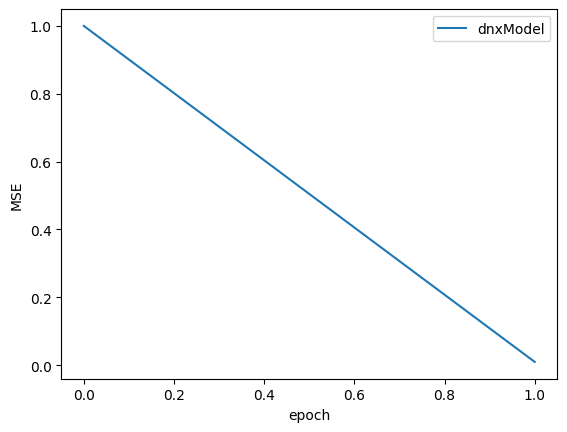

In [27]:
plt.figure()
plt.plot(dnxModel, label='dnxModel')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

## PyTorch CNN

In [ ]:
# numChannels:
# 1 -> grayscale or binary
# 3 -> rgb
# classes:
# number of output classes

class BasicModel(nn.Module):
    def __init__(self, numChannels, classes):
         # call the parent constructor:
        super().__init__()

        # initialize first set of CONV => RELU => POOL layers
        self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
			kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
		
        # initialize first (and only) set of FC => RELU layers
        #self.fc1 = Linear(in_features=800, out_features=500)
        self.fc1 = DynexLayer(in_features=800, out_features=500)
        self.relu3 = ReLU()
		
        # initialize our softmax classifier
        self.fc2 = Linear(in_features=500, out_features=classes)
        self.logSoftmax = LogSoftmax(dim=1)
        
        #self.conv = nn.Conv2d(1, 128, 3)
        #self.linear = DynexLayer(256, 2);
        

    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>
		# POOL layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
		# pass the output from the previous layer through the second
		# set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
		# flatten the output from the previous layer and pass it
		# through our only set of FC => RELU layers
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
		# pass the output to our softmax classifier to get our output
		# predictions
        x = self.fc2(x)
        output = self.logSoftmax(x)
		# return the output predictions
        return output
        
        #x = self. conv(x)
        #x = x.view(-1, 256)
        #return self.linear(x)

In [ ]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# load the MNIST dataset
from torchvision.datasets import MNIST
print("[INFO] loading the MNIST dataset...")
trainData = MNIST(root="data", train=True, download=True,
	transform=ToTensor())
testData = MNIST(root="data", train=False, download=True,
	transform=ToTensor())

In [ ]:
# load the CIFAR10 dataset
#from torchvision.datasets import CIFAR10
#print("[INFO] loading the CIFAR10 dataset...")
#trainData = CIFAR10(root="data", train=True, download=True,
#	transform=ToTensor())
#testData = CIFAR10(root="data", train=False, download=True,
#	transform=ToTensor())

In [ ]:
# calculate the train/validation split
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))
print(numTrainSamples,'train samples and',numValSamples,'validation samples');

In [ ]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True,
	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)

In [ ]:
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE
print(trainSteps,'train steps and',valSteps,'validation steps');

In [ ]:
# initialize the model
print("[INFO] initializing the model...")
model = BasicModel(numChannels=1, classes=len(trainData.dataset.classes)).to(device)

In [ ]:
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()

In [ ]:
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}

## Train the model

In [ ]:
# TRAIN: loop over our epochs

for e in range(0, EPOCHS):
	# set the model in training mode
	model.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValLoss = 0
	# initialize the number of correct predictions in the training
	# and validation step
	trainCorrect = 0
	valCorrect = 0
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# zero out the gradients, perform the backpropagation step,
		# and update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far and
		# calculate the number of correct predictions
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()
	
    # EVALUATE: switch off autograd for evaluation
	with torch.no_grad():
    	# set the model in evaluation mode
		model.eval()
    	# loop over the validation set
		for (x, y) in valDataLoader:
        	# send the input to the device
		    (x, y) = (x.to(device), y.to(device))
        	# make the predictions and calculate the validation loss
		    pred = model(x)
		    totalValLoss += lossFn(pred, y)
        	# calculate the number of correct predictions
		    valCorrect += (pred.argmax(1) == y).type(
                torch.float).sum().item()

	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValLoss = totalValLoss / valSteps
	# calculate the training and validation accuracy
	trainCorrect = trainCorrect / len(trainDataLoader.dataset)
	valCorrect = valCorrect / len(valDataLoader.dataset)
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["train_acc"].append(trainCorrect)
	H["val_loss"].append(avgValLoss.cpu().detach().numpy())
	H["val_acc"].append(valCorrect)
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
	print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
        avgTrainLoss, trainCorrect))
	print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
        avgValLoss, valCorrect))

## Statistics

In [ ]:
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()
	
	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

## Plot Results

In [ ]:
# plot the training loss and accuracy
#plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
#plt.savefig(args["plot"])
# serialize the model to disk
#torch.save(model, args["model"])

In [ ]:
H

In [ ]:
H